In [1]:
import numpy as np
import pandas as pd
import pickle
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from matplotlib import pyplot
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
%matplotlib inline

### Data Preparation

In [2]:
# loading full dataframe
final_df = pd.read_csv('final_df.csv')

In [3]:
# checking for null values
final_df.isna().sum()

title               1
artist              1
track_id            0
genre               0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
dtype: int64

In [4]:
# dropping null values
final_df.dropna(inplace=True)

In [5]:
# resetting index
final_df.reset_index(drop=True, inplace=True)

### Handling Data Imbalance Through Upsampling

In [6]:
genre_count = final_df['genre'].value_counts()
genre_count

house        1285
pop          1057
rock          995
country       747
metal         685
hiphop        680
techno        547
dance         522
jazz          487
kpop          397
classical     276
rnb           238
Name: genre, dtype: int64

In [7]:
# setting a minimum number of sample for main genres - house, pop, rock, country, hiphop, techno, dance, rnb
min_main_genre_count = 800

In [8]:
# setting a minimum number of sample for minor genres - metal, jazz, kpop, classical
min_minor_genre_count = 300

In [9]:
# genres with samples more than min_main_genre_count
genre_count[genre_count > min_main_genre_count].index

Index(['house', 'pop', 'rock'], dtype='object')

In [10]:
# retaining data for genres with samples more than min_main_genre_count
genre_house = final_df[final_df['genre'] == 'house']
genre_pop = final_df[final_df['genre'] == 'pop']
genre_rock = final_df[final_df['genre'] == 'rock']

In [11]:
# genres with samples less than min_main_genre_count
genre_count[genre_count < min_main_genre_count].index

Index(['country', 'metal', 'hiphop', 'techno', 'dance', 'jazz', 'kpop',
       'classical', 'rnb'],
      dtype='object')

In [12]:
# upsampling data for main genres with samples less than min_main_genre_count (excluding metal, jazz, kpop and cl)
genre_country = final_df[final_df['genre']=='country'].sample(min_main_genre_count, replace=True)
genre_hiphop = final_df[final_df['genre']=='hiphop'].sample(min_main_genre_count, replace=True)
genre_techno = final_df[final_df['genre']=='techno'].sample(min_main_genre_count, replace=True)
genre_dance = final_df[final_df['genre']=='dance'].sample(min_main_genre_count, replace=True)
genre_rnb = final_df[final_df['genre']=='rnb'].sample(min_main_genre_count, replace=True)

In [13]:
# genres with samples less than min_minor_genre_count
genre_count[genre_count < min_minor_genre_count].index

Index(['classical', 'rnb'], dtype='object')

In [14]:
# upsampling data for minor genres with samples less than min_minor_genre_count
genre_jazz = final_df[final_df['genre']=='jazz'].sample(min_minor_genre_count, replace=True)
genre_classical = final_df[final_df['genre']=='classical'].sample(min_minor_genre_count, replace=True)

In [15]:
# downsampling data for minor genres with samples more than min_minor_genre_count
genre_metal = final_df[final_df['genre']=='metal'].sample(min_minor_genre_count, replace=True)
genre_kpop = final_df[final_df['genre']=='kpop'].sample(min_minor_genre_count, replace=True)

In [16]:
# concatetnating all genre dataframes after upsampling
upsampled_df = pd.concat([genre_house, genre_pop, genre_rock, genre_country, genre_metal, genre_hiphop, genre_techno, genre_dance, genre_jazz,  genre_kpop, genre_classical, genre_rnb], axis=0)

In [17]:
# calculating supposed total numbers of tracks after upsampling
genre_count[genre_count > min_main_genre_count].values.sum()+len(genre_count[genre_count < min_main_genre_count].index)*min_main_genre_count-4*min_minor_genre_count

9337

In [18]:
# checking total numbers of tracks in new dataframe
len(upsampled_df)

8537

In [19]:
# resetting index
upsampled_df.reset_index(drop=True, inplace=True)

### Clustering
#### Scaling Data

In [20]:
# creating a dataframe for only audio features
X = upsampled_df.drop(columns=['title','artist', 'genre', 'track_id'])

In [21]:
# scaling the audio features dataframe
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns = X.columns)
display(X.head())
print()
display(X_scaled_df.head())

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,0.721,0.923,11,-4.497,0,0.0370,0.00299,0.03120,0.0989,0.575,128.748
1,0.805,0.660,5,-11.972,0,0.0897,0.01790,0.29500,0.3340,0.147,133.002
2,0.722,0.990,7,-5.103,1,0.0667,0.02090,0.00186,0.2620,0.398,122.991
3,0.691,0.830,0,-9.189,1,0.0450,0.06010,0.75800,0.4050,0.830,128.912
4,0.761,0.808,11,-5.629,0,0.0518,0.00258,0.00003,0.0869,0.157,119.931


,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,0.518102,0.972188,1.578355,0.709863,-1.171907,-0.604329,-0.641137,-0.478012,-0.549180,0.192326,0.279472
1,1.044512,-0.194485,-0.096595,-0.892029,-1.171907,0.034181,-0.583699,0.348700,0.985875,-1.549663,0.446829
2,0.524369,1.269401,0.461722,0.579997,0.853310,-0.244486,-0.572142,-0.569960,0.515760,-0.528076,0.052986
3,0.330098,0.559638,-1.492387,-0.295632,0.853310,-0.507402,-0.421132,1.799677,1.449460,1.230193,0.285924
4,0.768773,0.462046,1.578355,0.467276,-1.171907,-0.425014,-0.642716,-0.575696,-0.627532,-1.508962,-0.067398


#### Elbow Method

Training a K-Means model with 8 clusters! 

Training a K-Means model with 9 clusters! 

Training a K-Means model with 10 clusters! 

Training a K-Means model with 11 clusters! 

Training a K-Means model with 12 clusters! 

Training a K-Means model with 13 clusters! 

Training a K-Means model with 14 clusters! 

Training a K-Means model with 15 clusters! 

Training a K-Means model with 16 clusters! 

Training a K-Means model with 17 clusters! 

Training a K-Means model with 18 clusters! 

Training a K-Means model with 19 clusters! 

Training a K-Means model with 20 clusters! 

Training a K-Means model with 21 clusters! 

Training a K-Means model with 22 clusters! 

Training a K-Means model with 23 clusters! 

Training a K-Means model with 24 clusters! 

Training a K-Means model with 25 clusters! 

Training a K-Means model with 26 clusters! 

Training a K-Means model with 27 clusters! 

Training a K-Means model with 28 clusters! 

Training a K-Means model with 29 clusters! 

Training a K

Text(0.5, 1.0, 'Elbow Method showing the optimal k')

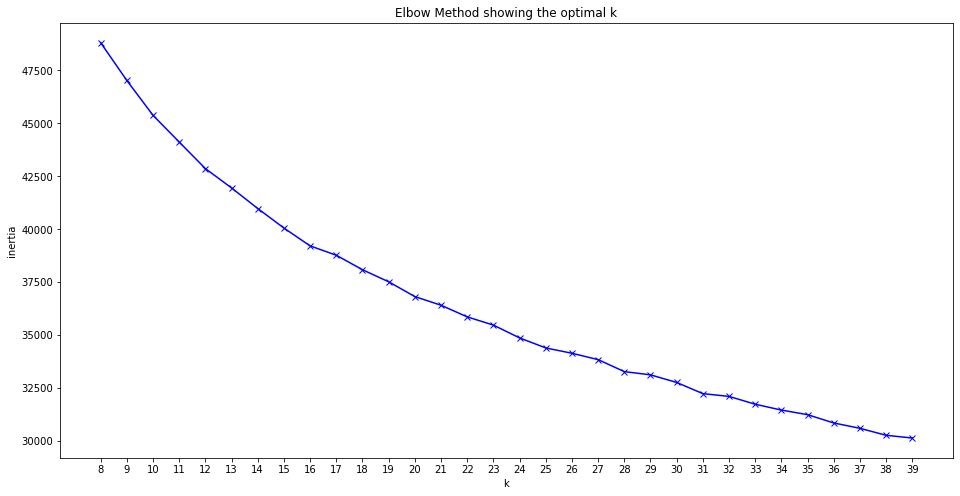

In [22]:
K = range(8, 40)
inertia = []

for k in K:
    print("Training a K-Means model with {} clusters! ".format(k))
    print()
    kmeans = KMeans(n_clusters=k,
                    random_state=345)
    kmeans.fit(X_scaled_df)
    inertia.append(kmeans.inertia_)
    
plt.figure(figsize=(16,8))
plt.plot(K, inertia, 'bx-')
plt.xlabel('k')
plt.ylabel('inertia')
plt.xticks(np.arange(min(K), max(K)+1, 1.0))
plt.title('Elbow Method showing the optimal k')

#### Silhouette Method

Text(0.5, 1.0, 'Silhouette Method showing the optimal k')

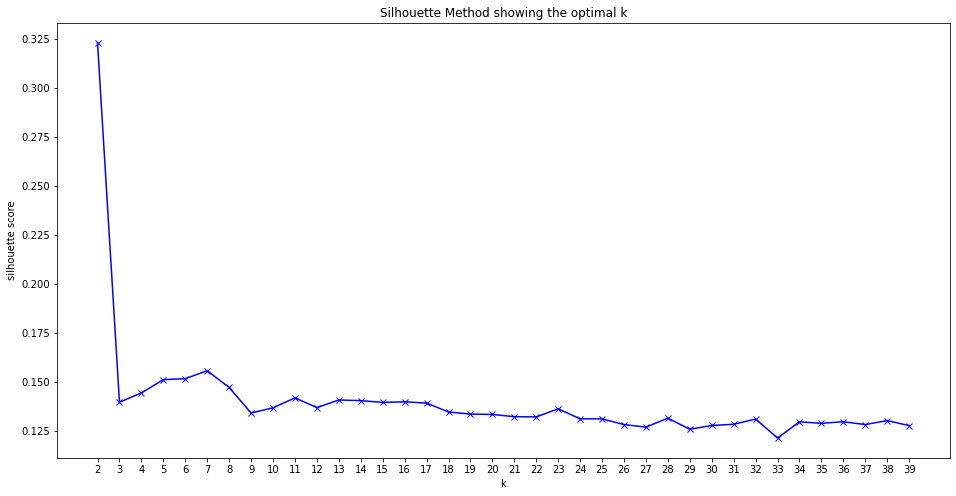

In [23]:
K = range(2, 40)
silhouette = []

for k in K:
    kmeans = KMeans(n_clusters=k,
                    n_init=50,
                    random_state=345)
    kmeans.fit(X_scaled_df)
    
    filename = "Model/kmeans_" + str(k) + ".pickle"
    with open(filename, "wb") as f:
        pickle.dump(kmeans,f)
    
    silhouette.append(silhouette_score(X_scaled_df, kmeans.predict(X_scaled_df)))


plt.figure(figsize=(16,8))
plt.plot(K, silhouette, 'bx-')
plt.xlabel('k')
plt.ylabel('silhouette score')
plt.xticks(np.arange(min(K), max(K)+1, 1.0))
plt.title('Silhouette Method showing the optimal k')

### Finalizing Database

In [24]:
# setting up clusters, using 21 based on Silhouette
kmeans = KMeans(n_clusters=21, random_state=345)
kmeans.fit(X_scaled_df)

KMeans(n_clusters=21, random_state=345)

In [25]:
kmeans.inertia_

36411.447402662234

In [26]:
clusters = kmeans.predict(X_scaled_df)
pd.Series(clusters).value_counts().sort_index()

0     678
1     407
2     267
3     512
4     318
5     338
6     651
7     273
8     411
9     340
10    541
11    378
12    436
13    503
14    587
15    237
16    412
17    388
18    321
19    353
20    186
dtype: int64

In [27]:
# integrating cluster into dataframe
upsampled_df['cluster'] = clusters

In [28]:
# saving the upsampled dataframe to a csv
from pathlib import Path  
filepath = Path('upsampled_df.csv')  
filepath.parent.mkdir(parents=True, exist_ok=True)
upsampled_df.to_csv(filepath, index=False)

In [29]:
# saving models
with open("Model/scaler.pickle", "wb") as f:
    pickle.dump(scaler,f)
with open("Model/kmeans.pickle", "wb") as f:
    pickle.dump(kmeans,f)

In [30]:
for i in range(0, max(upsampled_df['cluster']+1)):
    print('Cluster '+str(i)+': '+str(len(upsampled_df[upsampled_df['cluster']==i])))
    print(upsampled_df[upsampled_df['cluster']==i].genre.value_counts().index[0:3])
    print('\n')

Cluster 0: 678
Index(['house', 'pop', 'dance'], dtype='object')


Cluster 1: 407
Index(['rock', 'house', 'metal'], dtype='object')


Cluster 2: 267
Index(['classical', 'jazz'], dtype='object')


Cluster 3: 512
Index(['rock', 'metal', 'country'], dtype='object')


Cluster 4: 318
Index(['hiphop', 'rnb', 'pop'], dtype='object')


Cluster 5: 338
Index(['techno', 'house', 'dance'], dtype='object')


Cluster 6: 651
Index(['house', 'pop', 'country'], dtype='object')


Cluster 7: 273
Index(['hiphop', 'rnb', 'pop'], dtype='object')


Cluster 8: 411
Index(['rnb', 'pop', 'hiphop'], dtype='object')


Cluster 9: 340
Index(['country', 'pop', 'rock'], dtype='object')


Cluster 10: 541
Index(['house', 'dance', 'pop'], dtype='object')


Cluster 11: 378
Index(['country', 'pop', 'jazz'], dtype='object')


Cluster 12: 436
Index(['rock', 'country', 'pop'], dtype='object')


Cluster 13: 503
Index(['house', 'techno', 'dance'], dtype='object')


Cluster 14: 587
Index(['house', 'pop', 'dance'], dtype='object')

In [31]:
upsampled_df[upsampled_df['cluster']==i].genre.value_counts().index[0:2]

Index(['jazz', 'classical'], dtype='object')